# Exploratory Data Analysis

## Data overview

The data provided in this competition/dataset consists of three parts:
1. Gridded weather forecasts over Sweden splitted in daily NetCDF files
2. Aggregate wind power production in the four different swedish price regions
3. A record of swedish wind turbines and their location.

The gridded weather forecasts are provided as 10 ensembles on a 71×169 projection coordinate grid centered over Sweden and contain the following variables:

|   Variable name  |               Long name               | Unit |
|:----------------:|:-------------------------------------:|:----:|
|    Temperature   |       Surface temperature (T2M)       |   K  |
|      Wind_U      |       Zonal 10 metre wind (U10M)      |  m/s |
|      Wind_V      |    Meridional 10 metre wind (V10M)    |  m/s |
|   WindGustSpeed  |               Wind gust               |  m/s |
|     Pressure     |     Mean Sea Level Pressure (MSLP)    |  Pa  |
| RelativeHumidity | Screen level relative humidity (RH2M) |   –  |
|    CloudCover    |        Total cloud cover (TCC)        |   –  |

Since every NetCDF file contains hourly values for one day (24 time steps) this means that the shape of the variables in each file is:

(time steps, height levels, ensembles, x_coordinates, y_coordinates) = (24, 1, 10, 169, 71)

The wind power production data is given as aggregates over each price region (SE1, SE2, SE3, SE4) in MWh/h. Since wind power capacity has grown over the course of the 24 months of competition data, we also provide you with a record of wind turbine installations. This record is quality check as good as we could but there might be discrepancies compared to reality. For example, according to the Swedish Wind Power Association there were 4099 wind turbines in Sweden constituting 8984 MW of installed capacity. In the record provided there are only 4004 wind turbines constituting 8640 MW of installed capacity. It is anticipated that the provided wind turbine record could be useful in understanding geographical clusters of wind turbines as well as the growth of installed capacity.

In the illustration below the wind turbines are plotted (left) as well as ten-to-one downsample version of the gridded NWP data (right).

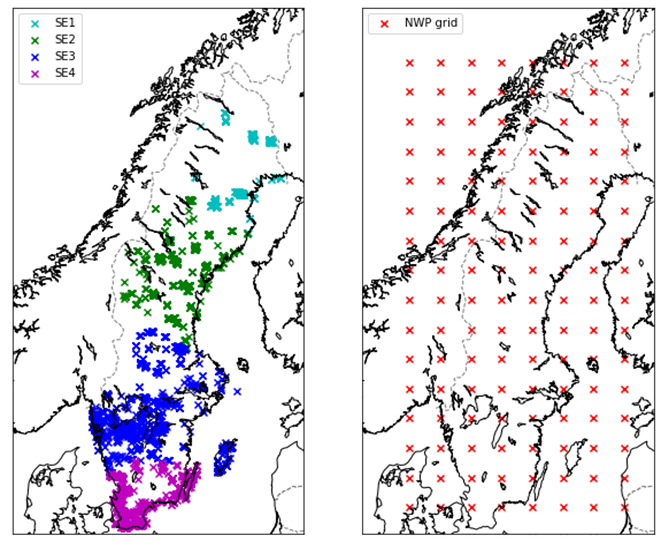

## Importing Libraries

In [1]:
import xarray as xr
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import math
from statsmodels.graphics.tsaplots import plot_acf

import torch.nn as nn

import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import plotly
import plotly.express as px
import datetime

import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [2]:
from pathlib import Path
import sys

DIRPATH= str(Path.cwd().parents[1])

module_path = DIRPATH + "/src"
if module_path not in sys.path:
    sys.path.append(module_path)
from utils.eem2020 import load_NWP, load_wind_power, load_max_power, load_turbine_map, load_wind_power_TS, load_wind_turbines

## Data Analysis

In [3]:
plt.style.use('seaborn-paper')
colors = ["#1E64C8", "#FFD200"]

### Wind Turbine data

In [4]:
df_wt = load_wind_turbines()
df_wt.head()

,Terrain height [m],Nacelle height [m],Rotor diameter [m],Max power [MW],Price region,Installation date,Longitude,Latitude
Wind turbine ID,,,,,,,,
1781-V-010-001,65.12,30.0,14.0,0.02,SE3,1881-12-31,14.133793,59.253088
1785-V-006-001,59.07,16.0,11.0,0.01,SE3,1881-12-31,12.802235,59.380151
1880-V-020-001,45.05,16.0,NaN,0.02,SE3,1881-12-31,15.075022,59.178468
2321-V-002-001,413.00,NaN,NaN,0.02,SE2,1881-12-31,13.376852,63.437566
2321-V-001-001,413.58,NaN,NaN,0.10,SE2,1881-12-31,13.376548,63.436982


In [5]:
df_wt.describe()

,Terrain height [m],Nacelle height [m],Rotor diameter [m],Max power [MW],Longitude,Latitude
count,3925.000000,3974.000000,3973.000000,4004.000000,4004.000000,4004.000000
mean,255.645103,92.617011,90.003775,2.157952,15.659946,60.249958
std,214.434754,27.377253,30.669686,1.027725,2.687755,3.419027
min,0.810000,1.000000,1.000000,0.000000,11.256855,55.359889
25%,67.190000,76.000000,72.000000,1.800000,13.468480,57.209975
50%,211.970000,98.000000,90.000000,2.200000,15.191858,58.929271
75%,426.320000,112.000000,112.000000,3.000000,17.174779,63.490714
max,1002.860000,152.000000,142.000000,4.200000,23.729241,67.874193


In [6]:
df_wt[df_wt["Max power [MW]"]<0.01]

,Terrain height [m],Nacelle height [m],Rotor diameter [m],Max power [MW],Price region,Installation date,Longitude,Latitude
Wind turbine ID,,,,,,,,
1864-V-001-001,259.17,12.0,6.0,0.0,SE3,1990-07-24,14.977052,60.039643
1290-V-064-001,23.50,13.0,21.0,0.0,SE4,1992-01-01,13.982492,56.061337


In [7]:
df_wt[df_wt["Nacelle height [m]"]<2]

,Terrain height [m],Nacelle height [m],Rotor diameter [m],Max power [MW],Price region,Installation date,Longitude,Latitude
Wind turbine ID,,,,,,,,
1421-V-006-001,59.59,1.0,1.0,0.01,SE3,1979-01-01,11.549657,58.159005
0483-V-008-003,59.70,1.0,1.0,0.08,SE3,1993-12-31,16.208652,59.008774
0483-V-008-002,60.88,1.0,1.0,0.08,SE3,1993-12-31,16.208519,59.008906
0483-V-008-001,60.13,1.0,1.0,0.08,SE3,1993-12-31,16.208341,59.009086
0483-V-008-011,49.34,1.0,1.0,0.08,SE3,1993-12-31,16.206849,59.008527
0483-V-008-004,57.99,1.0,1.0,0.08,SE3,1993-12-31,16.208805,59.008535
0483-V-008-005,57.77,1.0,1.0,0.08,SE3,1993-12-31,16.208531,59.008535
0483-V-008-006,56.26,1.0,1.0,0.08,SE3,1993-12-31,16.208231,59.008526
0483-V-008-007,55.90,1.0,1.0,0.08,SE3,1993-12-31,16.208001,59.008540


#### Aggregated Capacity Price Regions

**Aggregated capacity 2000-01-01**

In [8]:
#df_wt[df_wt["Installation date"]<"2001-01-01"]

In [9]:
# fig, axs = plt.subplots(1,2, sharey=True)
# sns.barplot(x=df_wt[df_wt["Installation date"]<"2000-01-01"]["Price region"], y=df_wt[df_wt["Installation date"]<"2000-01-01"]["Max power [MW]"], order=['SE1','SE2','SE3', 'SE4'], estimator=sum, ci=None, ax=axs[0])
# axs[0].bar_label(axs[0].containers[0])
# axs[0].title.set_text("2000-01-01")
# axs[0].set(ylabel="Aggregated capacity [MW]")
# sns.barplot(x=df_wt["Price region"], y=df_wt["Max power [MW]"], order=['SE1','SE2','SE3', 'SE4'], estimator=sum,ci=None,ax=axs[1])
# axs[1].bar_label(axs[1].containers[0])
# axs[1].title.set_text("2001-12-31")
# axs[1].set(ylabel="Aggregated capacity [MW]")
# fig.savefig(DIRPATH + "/reports/plots/agg_capacity_regions.pdf")

#### Analysis of turbine variables

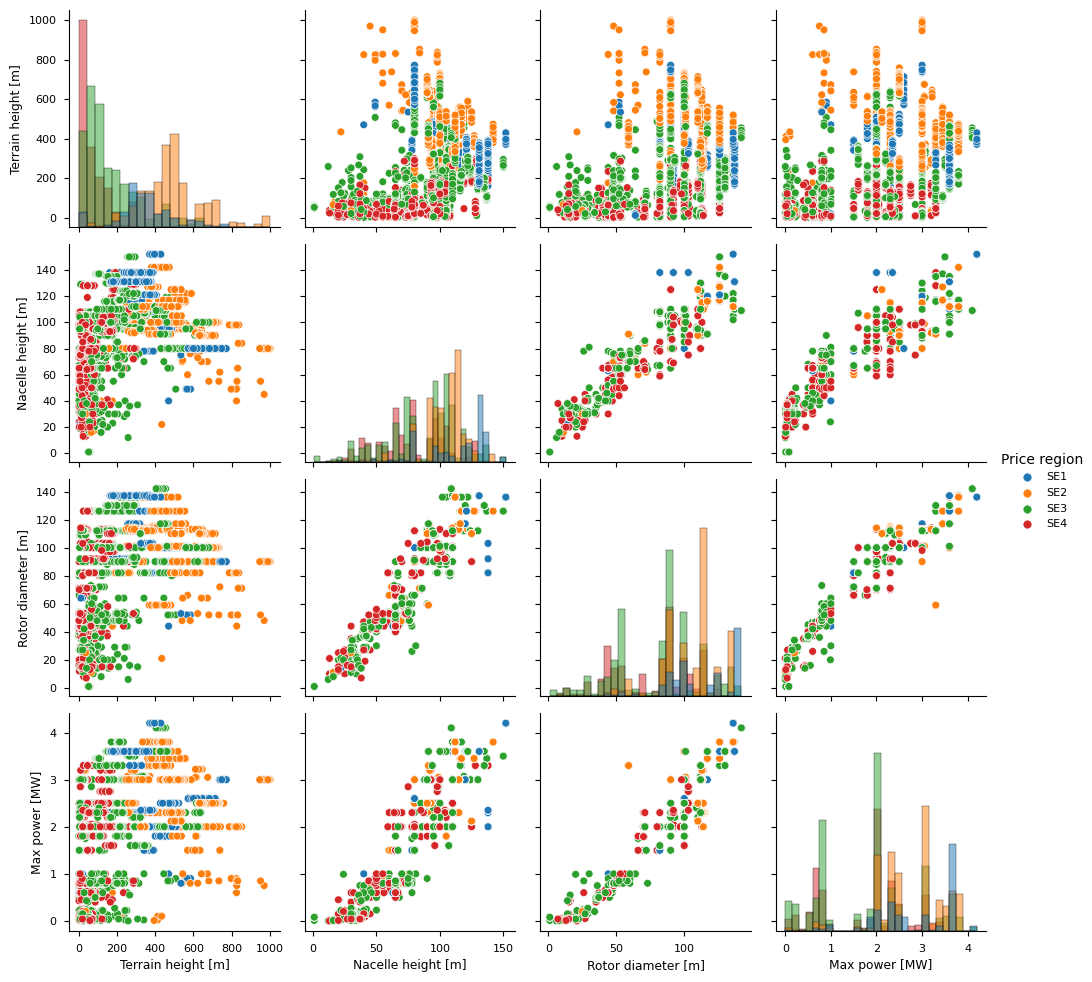

In [10]:
g = sns.PairGrid(df_wt.drop(columns={"Longitude","Latitude"}), hue="Price region", hue_order=['SE1','SE2','SE3', 'SE4'])
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend(label_order = ['SE1','SE2','SE3', 'SE4'])
fig = g.fig
fig.savefig(DIRPATH + "/reports/plots/pairwise_turbine_var.pdf")

##### Max power [MW]

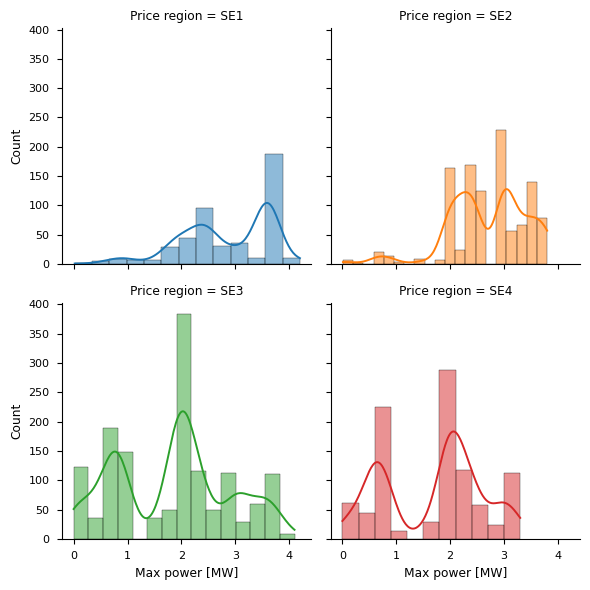

In [11]:
g = sns.FacetGrid(df_wt, col="Price region", col_wrap=2, col_order=['SE1','SE2','SE3', 'SE4'], hue_order=['SE1','SE2','SE3', 'SE4'], hue="Price region")
g.map(sns.histplot, "Max power [MW]", kde=True)
fig = g.fig
fig.savefig(DIRPATH + "/reports/plots/histogram_max_power.pdf")

##### Rotor diameter [m]

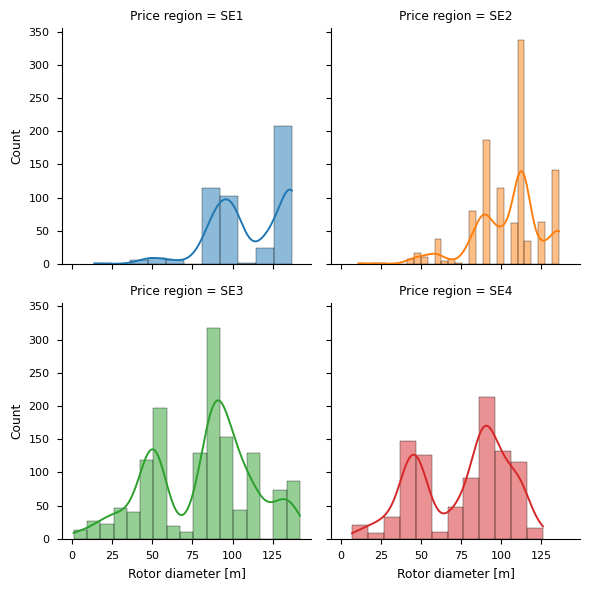

In [12]:
g = sns.FacetGrid(df_wt, col="Price region", col_wrap=2, col_order=['SE1','SE2','SE3', 'SE4'], hue_order=['SE1','SE2','SE3', 'SE4'], hue="Price region")
g.map(sns.histplot, "Rotor diameter [m]", kde=True)
fig = g.fig
fig.savefig(DIRPATH + "/reports/plots/histogram_rotor_diameter.pdf")

##### Nacelle height [m]

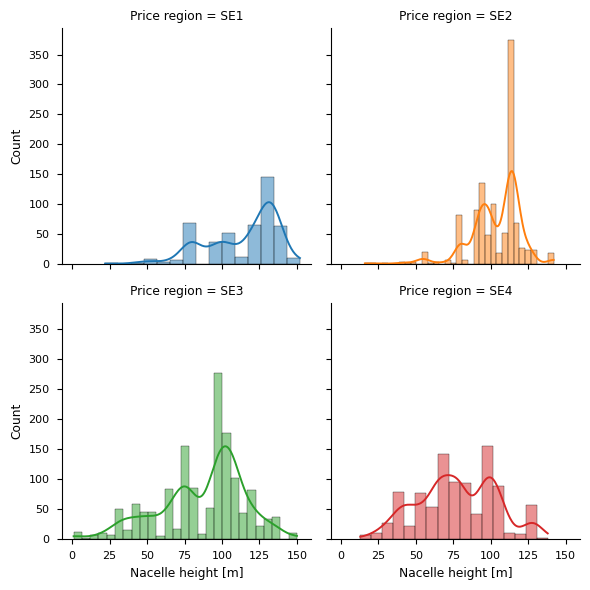

In [13]:
g = sns.FacetGrid(df_wt, col="Price region", col_wrap=2, col_order=['SE1','SE2','SE3', 'SE4'], hue_order=['SE1','SE2','SE3', 'SE4'], hue="Price region")
g.map(sns.histplot, "Nacelle height [m]", kde=True)
fig = g.fig
fig.savefig(DIRPATH + "/reports/plots/histogram_nacelle_height.pdf")

##### Terrain height [m]

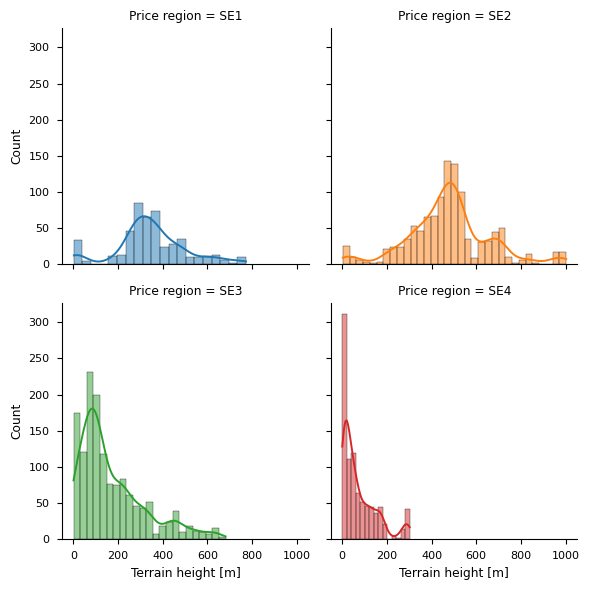

In [14]:
g = sns.FacetGrid(df_wt, col="Price region", col_wrap=2, col_order=['SE1','SE2','SE3', 'SE4'], hue_order=['SE1','SE2','SE3', 'SE4'], hue="Price region")
g.map(sns.histplot, "Terrain height [m]", kde=True)
fig = g.fig
fig.savefig(DIRPATH + "/reports/plots/histogram_terrain_height.pdf")

#### Geo plot of wind turbines

In [15]:
px.set_mapbox_access_token(open(".mapbox_token").read()) 
fig = px.density_mapbox(df_wt, lat="Latitude", lon="Longitude",
                       z="Max power [MW]", radius=4, center=dict(lat=62,lon=16),
                        zoom=3.15, mapbox_style="basic", color_continuous_scale=px.colors.cyclical.IceFire)
fig.update_geos(
    scope="europe")
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    width=400
)
fig.write_image(DIRPATH + "/reports/plots/mapbox_map.png")
fig.show()

In [16]:
fig = px.scatter_mapbox(df_wt, lat="Latitude", lon="Longitude",
                       color="Max power [MW]", color_continuous_scale=px.colors.cyclical.IceFire, center=dict(lat=62,lon=16),
                        zoom=3.15, mapbox_style="basic")
fig.update_geos(
    scope="europe")
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    width=400
)
fig.write_image(DIRPATH + "/reports/plots/mapbox_map_points.png")
fig.show()

In [17]:
fig = px.scatter_mapbox(df_wt, lat="Latitude", lon="Longitude",
                       color="Price region",category_orders={"Price region":['SE1','SE2','SE3', 'SE4']}, color_discrete_sequence=px.colors.qualitative.D3, center=dict(lat=62,lon=16),
                        zoom=3.15, mapbox_style="basic")
fig.update_geos(
    scope="europe")
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    width=400
)
fig.write_image(DIRPATH + "/reports/plots/mapbox_map_region.png")
fig.show()

#### Create cummalitive theoratical max power plot

In [18]:
df_wt["Installation date"] = pd.to_datetime(df_wt["Installation date"])
df_wt.sort_values("Installation date")
df_wt["Cum. power"] = df_wt["Max power [MW]"].cumsum()

In [19]:
dates = pd.date_range(start="20000101",end="20011231",freq="D")

In [20]:
np_wt_SE1 = load_max_power(start="20000101",end="20011231", SE="SE1", freq="D", adjust=False).reshape(len(dates))
np_wt_SE2 = load_max_power(start="20000101",end="20011231", SE="SE2", freq="D", adjust=False).reshape(len(dates))
np_wt_SE3 = load_max_power(start="20000101",end="20011231", SE="SE3", freq="D", adjust=False).reshape(len(dates))
np_wt_SE4 = load_max_power(start="20000101",end="20011231", SE="SE4", freq="D", adjust=False).reshape(len(dates))

In [21]:
df_max_power = pd.DataFrame(data={"date":pd.date_range(start="20000101",end="20011231",freq="D"),
                                  "SE1":np_wt_SE1,
                                  "SE2":np_wt_SE2,
                                  "SE3":np_wt_SE3,
                                  "SE4":np_wt_SE4})

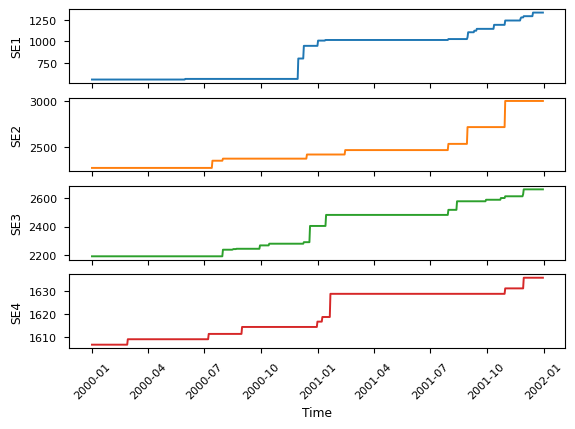

In [39]:
fig, axs = plt.subplots(4, sharex=True)
sns.lineplot(x="date", y="SE1", data=df_max_power, ax=axs[0], color=sns.color_palette()[0])
sns.lineplot(x="date", y="SE2", data=df_max_power, ax=axs[1], color=sns.color_palette()[1])
sns.lineplot(x="date", y="SE3", data=df_max_power, ax=axs[2], color=sns.color_palette()[2])
sns.lineplot(x="date", y="SE4", data=df_max_power, ax=axs[3], color=sns.color_palette()[3])
axs[3].tick_params("x",labelrotation=45)
axs[3].set_xlabel("Time")
fig.savefig(DIRPATH + "/reports/plots/max_power_timeseries.pdf")

#### Creating Turbine Maps

We will create turbine maps for each price regions with a size of 64x64. The images above, maps the theoratical max power of turbine to the closest grid point. The images beneath, maps the theoratical max power of turbine in weighted way based to distance to the four closest grid points.

##### SE1

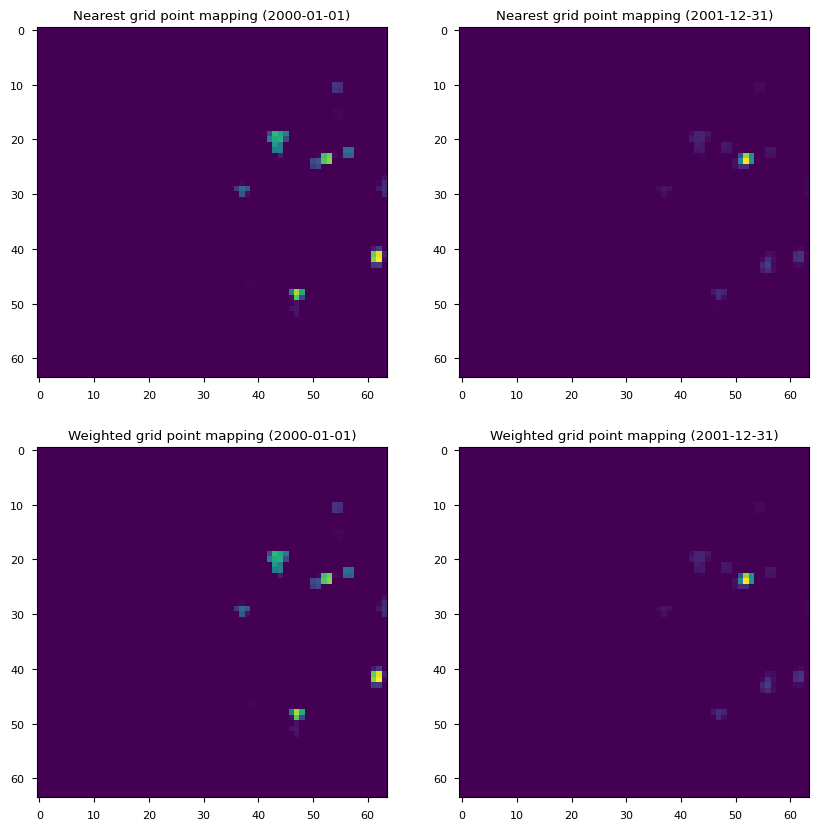

In [23]:
tur_map1 = load_turbine_map(start="20000101",end="20000101",SE="SE1")[0,92:156,7:]
tur_map_weighted1 = load_turbine_map(start="20000101",end="20000101",SE="SE1",close_one=False)[0,92:156,7:]
tur_map2 = load_turbine_map(start="20011231",end="20011231",SE="SE1")[0,92:156,7:]
tur_map_weighted2 = load_turbine_map(start="20011231",end="20011231",SE="SE1",close_one=False)[0,92:156,7:]
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(tur_map1)
ax[0,0].title.set_text("Nearest grid point mapping (2000-01-01)")
ax[1,0].imshow(tur_map_weighted1)
ax[1,0].title.set_text("Weighted grid point mapping (2000-01-01)")
ax[0,1].imshow(tur_map2)
ax[0,1].title.set_text("Nearest grid point mapping (2001-12-31)")
ax[1,1].imshow(tur_map_weighted2)
ax[1,1].title.set_text("Weighted grid point mapping (2001-12-31)")
fig.savefig(DIRPATH + "/reports/plots/turbine_map_comp_SE1.pdf")

##### SE2

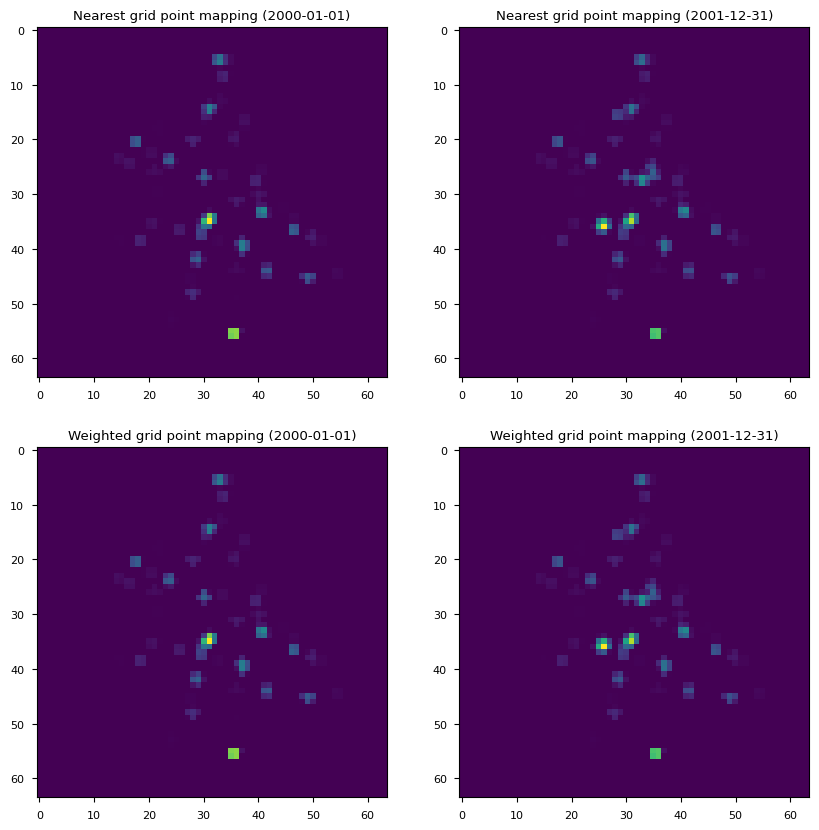

In [24]:
tur_map1 = load_turbine_map(start="20000101",end="20000101",SE="SE2")[0,58:122,7:71]
tur_map_weighted1 = load_turbine_map(start="20000101",end="20000101",SE="SE2",close_one=False)[0,58:122,7:71]
tur_map2 = load_turbine_map(start="20011231",end="20011231",SE="SE2")[0,58:122,7:71]
tur_map_weighted2 = load_turbine_map(start="20011231",end="20011231",SE="SE2",close_one=False)[0,58:122,7:71]
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(tur_map1)
ax[0,0].title.set_text("Nearest grid point mapping (2000-01-01)")
ax[1,0].imshow(tur_map_weighted1)
ax[1,0].title.set_text("Weighted grid point mapping (2000-01-01)")
ax[0,1].imshow(tur_map2)
ax[0,1].title.set_text("Nearest grid point mapping (2001-12-31)")
ax[1,1].imshow(tur_map_weighted2)
ax[1,1].title.set_text("Weighted grid point mapping (2001-12-31)")
fig.savefig(DIRPATH + "/reports/plots/turbine_map_comp_SE2.pdf")

##### SE3

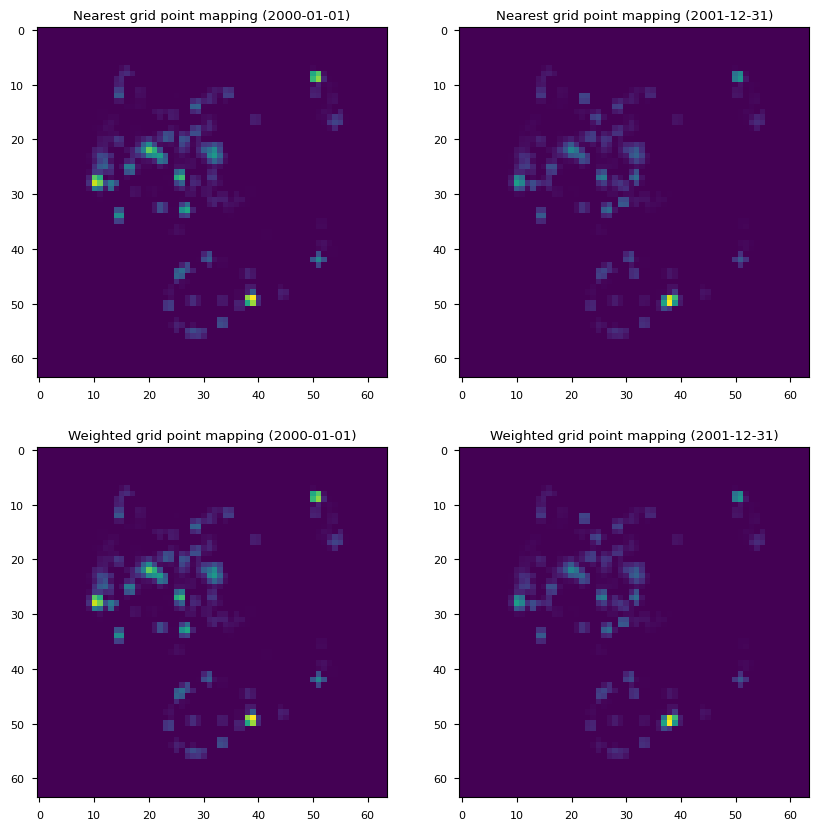

In [25]:
tur_map1 = load_turbine_map(start="20000101",end="20000101",SE="SE3")[0,14:78,1:65]
tur_map_weighted1 = load_turbine_map(start="20000101",end="20000101",SE="SE3",close_one=False)[0,14:78,1:65]
tur_map2 = load_turbine_map(start="20011231",end="20011231",SE="SE3")[0,14:78,1:65]
tur_map_weighted2 = load_turbine_map(start="20011231",end="20011231",SE="SE3",close_one=False)[0,14:78,1:65]
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(tur_map1)
ax[0,0].title.set_text("Nearest grid point mapping (2000-01-01)")
ax[1,0].imshow(tur_map_weighted1)
ax[1,0].title.set_text("Weighted grid point mapping (2000-01-01)")
ax[0,1].imshow(tur_map2)
ax[0,1].title.set_text("Nearest grid point mapping (2001-12-31)")
ax[1,1].imshow(tur_map_weighted2)
ax[1,1].title.set_text("Weighted grid point mapping (2001-12-31)")
fig.savefig(DIRPATH + "/reports/plots/turbine_map_comp_SE3.pdf")

##### SE4

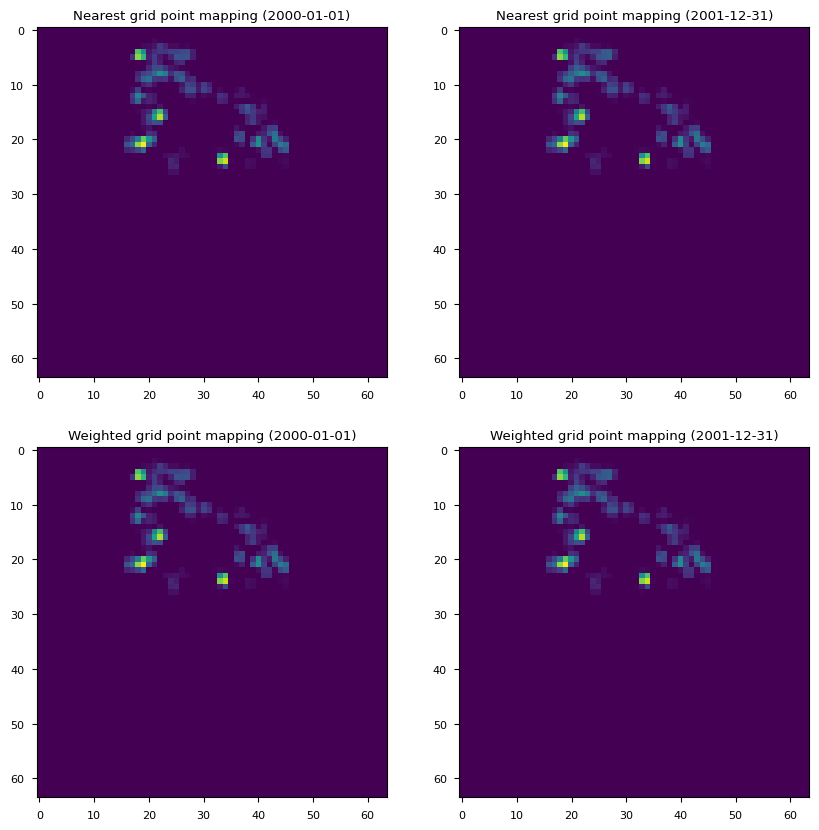

In [26]:
tur_map1 = load_turbine_map(start="20000101",end="20000101",SE="SE4")[0,0:64,0:64]
tur_map_weighted1 = load_turbine_map(start="20000101",end="20000101",SE="SE4",close_one=False)[0,0:64,0:64]
tur_map2 = load_turbine_map(start="20011231",end="20011231",SE="SE4")[0,0:64,0:64]
tur_map_weighted2 = load_turbine_map(start="20011231",end="20011231",SE="SE4",close_one=False)[0,0:64,0:64]
fig, ax = plt.subplots(2,2, figsize=(10,10))
ax[0,0].imshow(tur_map1)
ax[0,0].title.set_text("Nearest grid point mapping (2000-01-01)")
ax[1,0].imshow(tur_map_weighted1)
ax[1,0].title.set_text("Weighted grid point mapping (2000-01-01)")
ax[0,1].imshow(tur_map2)
ax[0,1].title.set_text("Nearest grid point mapping (2001-12-31)")
ax[1,1].imshow(tur_map_weighted2)
ax[1,1].title.set_text("Weighted grid point mapping (2001-12-31)")
fig.savefig(DIRPATH + "/reports/plots/turbine_map_comp_SE4.pdf")

### Wind Power Data

In [27]:
ds_wp = load_wind_power(start="20000101",end="20011231", adjust=False)
df_wp = ds_wp.to_dataframe()

In [28]:
df_wp["Max Power SE1"] = load_max_power(start="20000101",end="20011231",SE="SE1",freq="H",adjust=False)
df_wp["Max Power SE2"] = load_max_power(start="20000101",end="20011231",SE="SE2",freq="H",adjust=False)
df_wp["Max Power SE3"] = load_max_power(start="20000101",end="20011231",SE="SE3",freq="H",adjust=False)
df_wp["Max Power SE4"] = load_max_power(start="20000101",end="20011231",SE="SE4",freq="H",adjust=False)
df_wp["Max Power SE1 Adjusted"] = load_max_power(start="20000101",end="20011231",SE="SE1",freq="H",adjust=False, SE1_adjusted=True)
df_wp["Normalized SE1"] = df_wp["SE1"] / df_wp["Max Power SE1"]
df_wp["Normalized SE2"] = df_wp["SE2"] / df_wp["Max Power SE2"]
df_wp["Normalized SE3"] = df_wp["SE3"] / df_wp["Max Power SE3"]
df_wp["Normalized SE4"] = df_wp["SE4"] / df_wp["Max Power SE4"]
df_wp["Normalized SE1 Adjusted"] = df_wp["SE1"] / df_wp["Max Power SE1 Adjusted"]

#### Time series of hourly produced normalized power per price region

In the plot for price region SE1 we see that around december 2000 the normalized power goes above 1 which is theoretically impossible. This indicates errors in the wind turbine dataset where installation date for each turbine is stated and which is used to calculate max theoratical power for each price region.

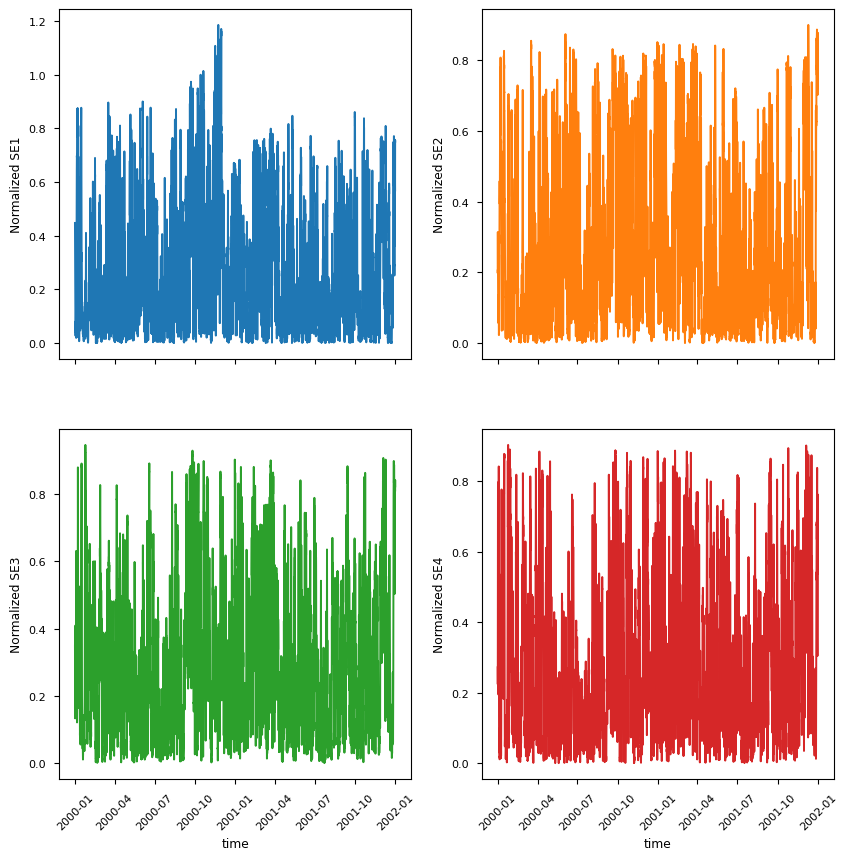

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10,10))
sns.lineplot(x="time",y="Normalized SE1",data=df_wp,ax=axs[0,0],color=sns.color_palette()[0])
sns.lineplot(x="time",y="Normalized SE2",data=df_wp,ax=axs[0,1],color=sns.color_palette()[1])
sns.lineplot(x="time",y="Normalized SE3",data=df_wp,ax=axs[1,0],color=sns.color_palette()[2])
sns.lineplot(x="time",y="Normalized SE4",data=df_wp,ax=axs[1,1],color=sns.color_palette()[3])
axs[1,0].tick_params("x",labelrotation=45)
axs[1,1].tick_params("x",labelrotation=45)
fig.savefig(DIRPATH + "/reports/plots/norm_hourly_power_TS.pdf")

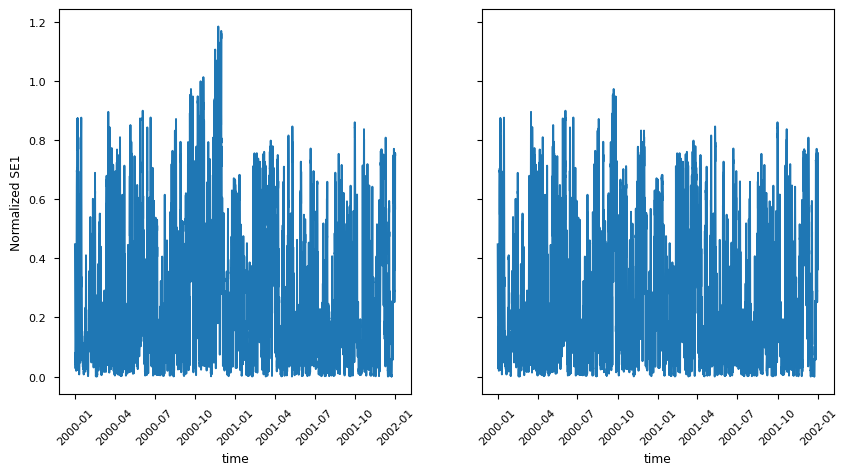

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,5))
sns.lineplot(x="time",y="Normalized SE1",data=df_wp,ax=axs[0])
sns.lineplot(x="time",y="Normalized SE1 Adjusted",data=df_wp,ax=axs[1])
axs[0].tick_params("x",labelrotation=45)
axs[1].tick_params("x",labelrotation=45)
fig.savefig(DIRPATH + "/reports/plots/norm_daily_power_TS_SE1_Adjusted.pdf", bbox_inches='tight')

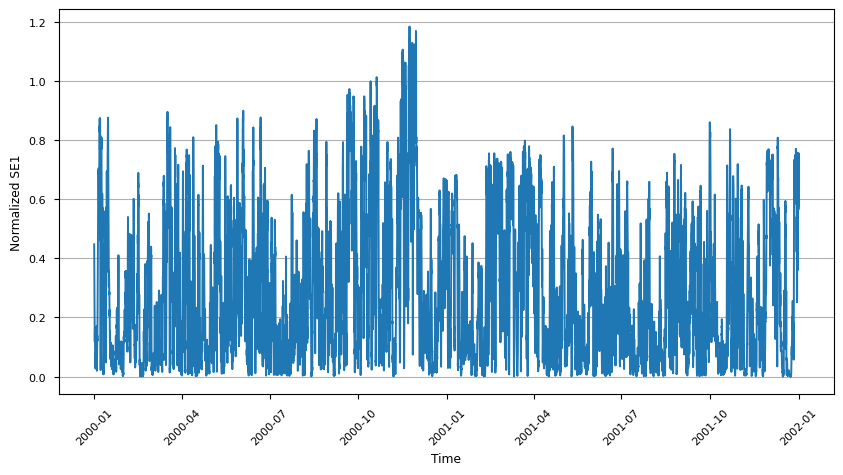

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(10,5))
sns.lineplot(x="time",y="Normalized SE1",data=df_wp,ax=axs)
axs.tick_params("x",labelrotation=45)
axs.grid(axis="y")
axs.set_xlabel("Time")
fig.savefig(DIRPATH + "/reports/plots/norm_daily_power_TS_SE1_Adjusted_part1.pdf", bbox_inches='tight')

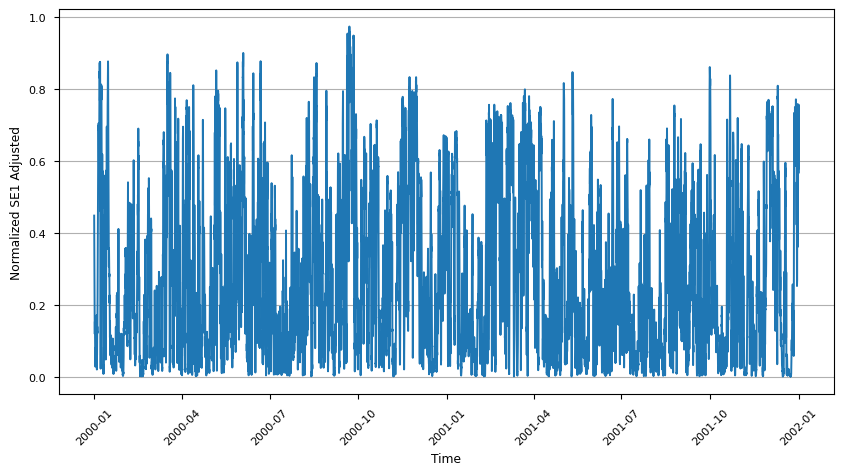

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(10,5))
sns.lineplot(x="time",y="Normalized SE1 Adjusted",data=df_wp,ax=axs)
axs.tick_params("x",labelrotation=45)
axs.grid(axis="y")
axs.set_xlabel("Time")
fig.savefig(DIRPATH + "/reports/plots/norm_daily_power_TS_SE1_Adjusted_part2.pdf", bbox_inches='tight')

#### Time series of monthly normalized power output for each price region

In [33]:
df_wp = df_wp.drop(columns=['Normalized SE1 Adjusted', 'Max Power SE1 Adjusted'])
ds_wp = xr.Dataset(df_wp)
ds_wp_month = ds_wp.resample(time="1M").mean()
df_wp_month = ds_wp_month.to_dataframe()
df_wp_month = df_wp_month.drop(columns=["SE1", "SE2", "SE3", "SE4", 
                                         "Max Power SE1", "Max Power SE2",
                                         "Max Power SE3", "Max Power SE4"])

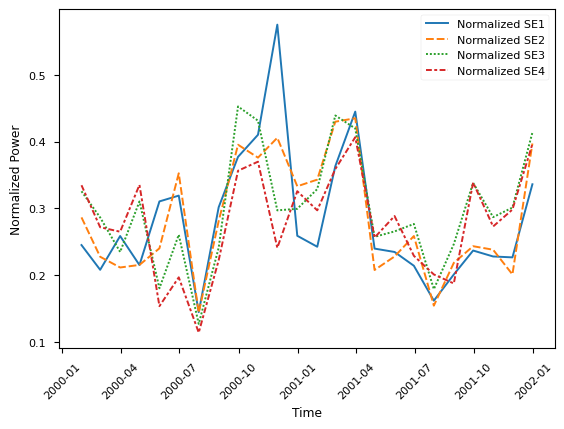

In [34]:
plot= sns.lineplot(data=df_wp_month)
plot.tick_params("x",labelrotation=45)
plot.set_ylabel("Normalized Power")
plot.set_xlabel("Time")
fig = plot.get_figure()
fig.savefig(DIRPATH + "/reports/plots/norm_monthly_power_TS.pdf")

#### Seasonality power production

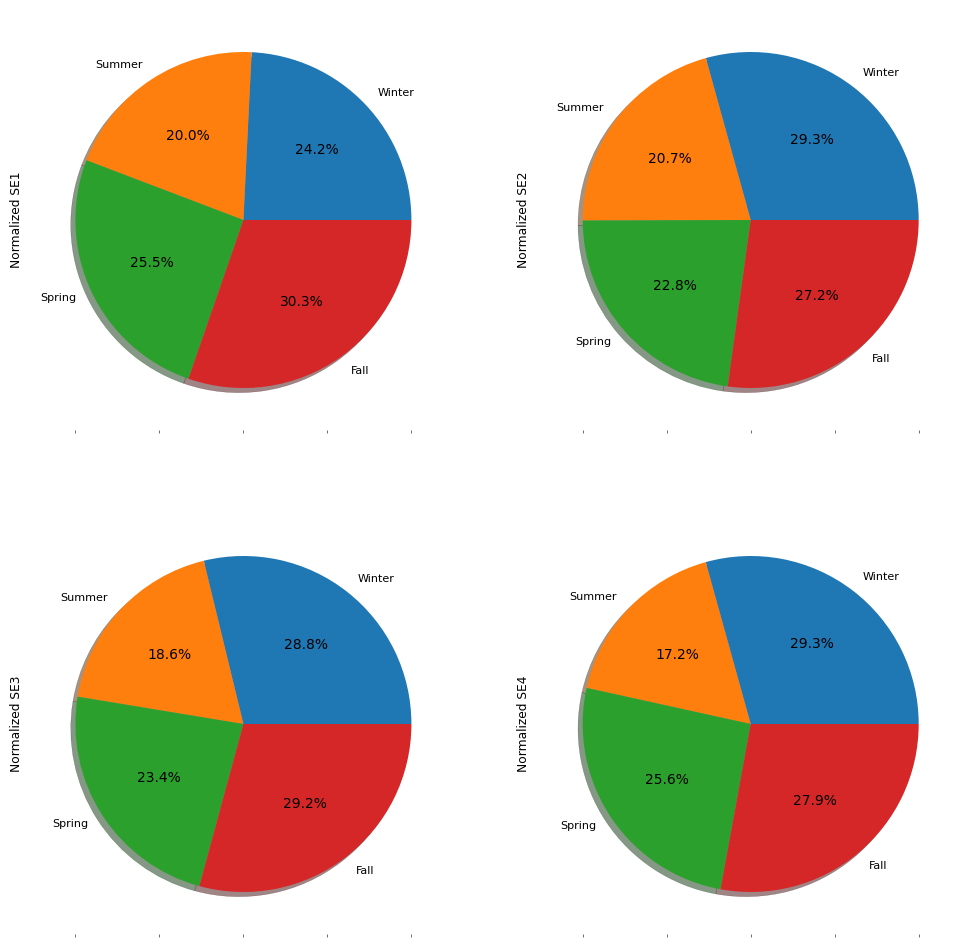

In [35]:
ds_wp_season = ds_wp.groupby("time.season").sum()
df_wp_season = ds_wp_season.to_dataframe()
df_wp_season = df_wp_season.drop(columns=["SE1", "SE2", "SE3", "SE4", 
                                         "Max Power SE1", "Max Power SE2",
                                         "Max Power SE3", "Max Power SE4"])
# MW to GW
df_wp_season /= 1000
df_wp_season = df_wp_season.rename(index={"DJF":"Winter", "MAM":"Spring", "JJA":"Summer", "SON": "Fall"})
colors = sns.color_palette("Blues")
ax = df_wp_season.plot.pie(subplots=True, figsize=(12,12), autopct='%1.1f%%', legend = False, layout=(2,2), shadow=True, colors=sns.color_palette())
plt.savefig(DIRPATH + "/reports/plots/pie_plot_power_seasons.pdf")

#### Average normalized hourly power production for each price region

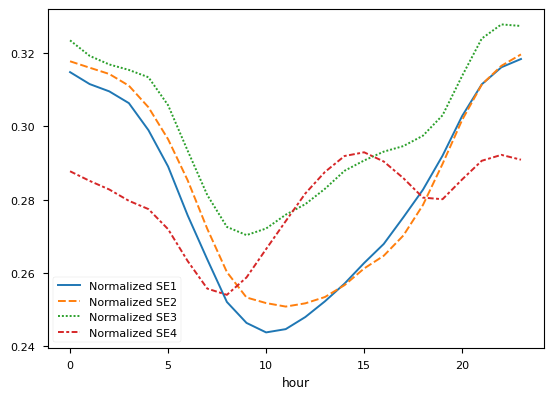

In [36]:
ds_wp_hour = ds_wp.groupby("time.hour").mean()
df_wp_hour = ds_wp_hour.to_dataframe()
df_wp_hour = df_wp_hour.drop(columns=["SE1", "SE2", "SE3", "SE4", 
                                         "Max Power SE1", "Max Power SE2",
                                         "Max Power SE3", "Max Power SE4"])
plot = sns.lineplot(data=df_wp_hour)
fig = plot.get_figure()
fig.savefig(DIRPATH + "/reports/plots/norm_hourly_power_avg.pdf")

#### Histogram of hourly power production

In [37]:
df_wp_norm = df_wp.drop(columns=["SE1", "SE2", "SE3", "SE4", 
                                         "Max Power SE1", "Max Power SE2",
                                         "Max Power SE3", "Max Power SE4"])

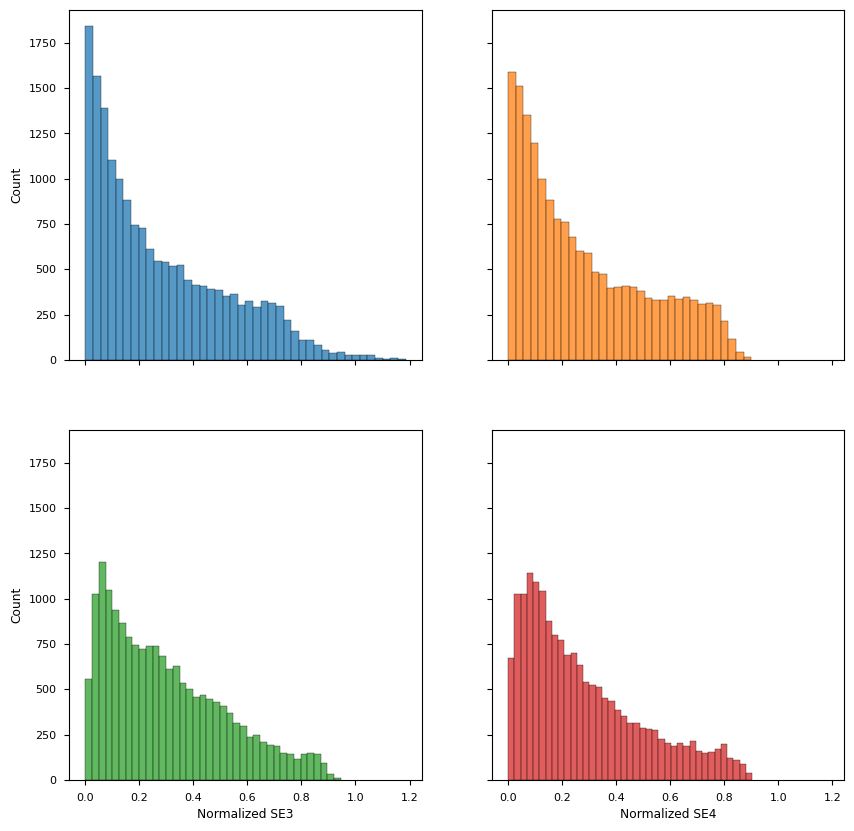

In [38]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
sns.histplot(data=df_wp_norm, x="Normalized SE1", ax=axs[0,0], color=sns.color_palette()[0])
sns.histplot(data=df_wp_norm, x="Normalized SE2", ax=axs[0,1], color=sns.color_palette()[1])
sns.histplot(data=df_wp_norm, x="Normalized SE3", ax=axs[1,0], color=sns.color_palette()[2])
sns.histplot(data=df_wp_norm, x="Normalized SE4", ax=axs[1,1], color=sns.color_palette()[3])
fig.savefig(DIRPATH + "/reports/plots/histogram_hourly_power_norm.pdf")

#### Autocorrelation of time series

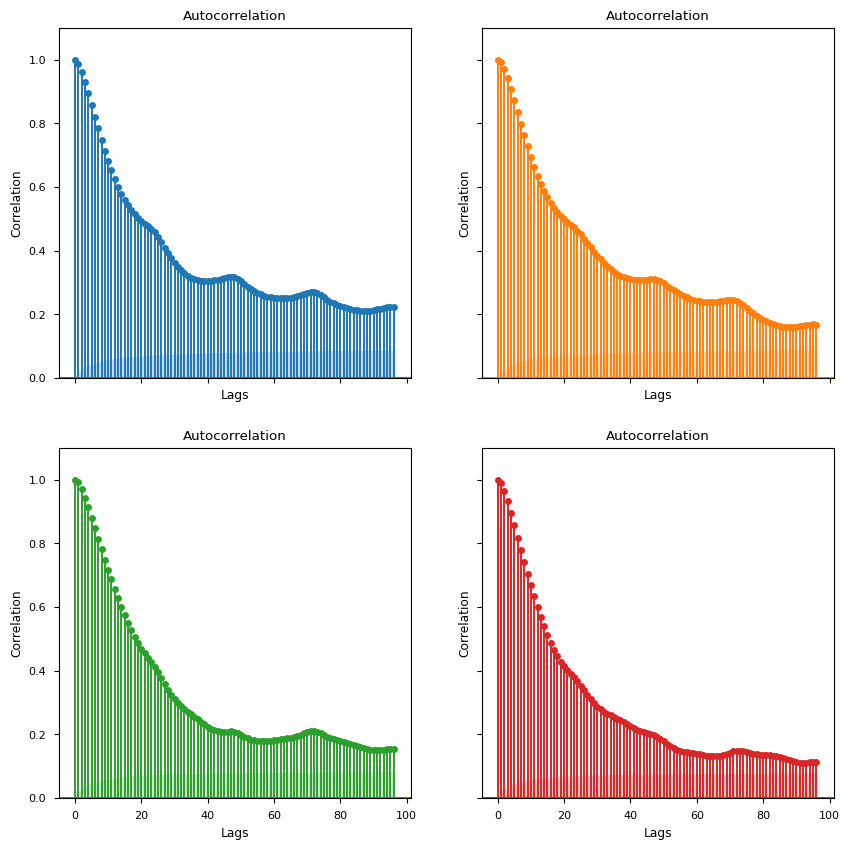

In [39]:
from matplotlib.collections import PolyCollection

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10,10))
plot_acf(x=df_wp_norm["Normalized SE1"], lags=96, ax=axs[0,0], color=sns.color_palette()[0], vlines_kwargs={"colors": sns.color_palette()[0]})
plot_acf(x=df_wp_norm["Normalized SE2"], lags=96, ax=axs[0,1], color=sns.color_palette()[1], vlines_kwargs={"colors": sns.color_palette()[1]})
plot_acf(x=df_wp_norm["Normalized SE3"], lags=96, ax=axs[1,0], color=sns.color_palette()[2], vlines_kwargs={"colors": sns.color_palette()[2]})
plot_acf(x=df_wp_norm["Normalized SE4"], lags=96, ax=axs[1,1], color=sns.color_palette()[3], vlines_kwargs={"colors": sns.color_palette()[3]})
for i, ax in enumerate(axs.flatten()):
    ax.set_ylim([0,1.1])
    ax.set_ylabel("Correlation")
    ax.set_xlabel("Lags")
    for item in ax.collections:
        if type(item)==PolyCollection:
            item.set_facecolor(sns.color_palette()[i])
fig.savefig(DIRPATH + "/reports/plots/autocorrelation_plot_power.pdf")

### NWP ensemble data

In [42]:
start, end = "20000101", "20001231"
files= list(pd.date_range(start=start, end=end, freq="D").strftime("%Y%m%d") + "T00Z.nc")
dirname = DIRPATH + "/data/eem20/raw"

ds_NWP_mean = xr.open_dataset(os.path.join(dirname,files.pop(0)))
ds_NWP_mean = ds_NWP_mean.mean(dim="ensemble_member")

for day in tqdm(files):
    if os.path.isfile(os.path.join(dirname,day)):
        temp_ds = xr.open_dataset(os.path.join(dirname,day))
        temp_ds = temp_ds.mean(dim="ensemble_member")
        #temp_ds = temp_ds.drop_vars("CloudCover").isel(y=slice(60,120), x=slice(11,71))
        ds_NWP_mean = ds_NWP_mean.combine_first(temp_ds)

100%|██████████| 365/365 [20:21<00:00,  3.35s/it]


In [43]:
ds_NWP_mean

<xarray.Dataset>
Dimensions:           (time: 8736, y: 169, x: 71)
Coordinates:
  * x                 (x) float32 -3.225e+05 -3.125e+05 ... 3.675e+05 3.775e+05
  * y                 (y) float32 -8.793e+05 -8.693e+05 ... 7.907e+05 8.007e+05
  * time              (time) datetime64[ns] 2000-01-01 ... 2000-12-31T23:00:00
    latitude          (y, x) float64 55.0 55.01 55.02 ... 69.95 69.94 69.92
    longitude         (y, x) float64 9.984 10.14 10.29 ... 24.33 24.59 24.85
Data variables:
    Temperature       (time, y, x) float32 280.0 279.8 279.5 ... 261.1 263.0
    RelativeHumidity  (time, y, x) float32 0.961 0.9545 0.9611 ... 0.9131 0.8485
    Wind_U            (time, y, x) float32 4.215 5.046 4.938 ... 5.331 9.449
    Wind_V            (time, y, x) float32 3.339 4.249 4.285 ... -8.615 -8.452
    Pressure          (time, y, x) float32 9.92e+04 9.922e+04 ... 1.01e+05
    CloudCover        (time, y, x) float32 0.9581 0.9952 0.9994 ... 0.6525 0.721
    WindGustSpeed     (time, y, x) float32 8.818 8.67 8.366 ... 14.44 17.45

In [44]:
ds_NWP_mean = ds_NWP_mean.assign(Wind=np.sqrt(ds_NWP_mean.Wind_U**2 + ds_NWP_mean.Wind_V**2))

In [45]:
ds_NWP_mean = ds_NWP_mean.assign(WindDensity= (ds_NWP_mean.Pressure/(287.05*ds_NWP_mean.Temperature))*(8/27)* (ds_NWP_mean.Wind**3) )

In [46]:
ds_NWP_mean

<xarray.Dataset>
Dimensions:           (time: 8736, y: 169, x: 71)
Coordinates:
  * x                 (x) float32 -3.225e+05 -3.125e+05 ... 3.675e+05 3.775e+05
  * y                 (y) float32 -8.793e+05 -8.693e+05 ... 7.907e+05 8.007e+05
  * time              (time) datetime64[ns] 2000-01-01 ... 2000-12-31T23:00:00
    latitude          (y, x) float64 55.0 55.01 55.02 ... 69.95 69.94 69.92
    longitude         (y, x) float64 9.984 10.14 10.29 ... 24.33 24.59 24.85
Data variables:
    Temperature       (time, y, x) float32 280.0 279.8 279.5 ... 261.1 263.0
    RelativeHumidity  (time, y, x) float32 0.961 0.9545 0.9611 ... 0.9131 0.8485
    Wind_U            (time, y, x) float32 4.215 5.046 4.938 ... 5.331 9.449
    Wind_V            (time, y, x) float32 3.339 4.249 4.285 ... -8.615 -8.452
    Pressure          (time, y, x) float32 9.92e+04 9.922e+04 ... 1.01e+05
    CloudCover        (time, y, x) float32 0.9581 0.9952 0.9994 ... 0.6525 0.721
    WindGustSpeed     (time, y, x) float32 8.818 8.67 8.366 ... 14.44 17.45
    Wind              (time, y, x) float32 5.377 6.597 6.538 ... 10.13 12.68
    WindDensity       (time, y, x) float32 56.87 105.1 102.4 ... 415.5 807.9

In [47]:
array = []
for var in ds_NWP_mean.data_vars:
    array.append(ds_NWP_mean[var].values.flatten())
array = np.array(array)

In [48]:
df = pd.DataFrame(array.T,columns=ds_NWP_mean.data_vars)

In [49]:
df.describe()

,Temperature,RelativeHumidity,Wind_U,Wind_V,Pressure,CloudCover,WindGustSpeed,Wind,WindDensity
count,1.048233e+08,1.048233e+08,1.048233e+08,1.048233e+08,1.048233e+08,1.048233e+08,1.048233e+08,1.048233e+08,1.048233e+08
mean,2.783559e+02,7.984867e-01,6.469419e-01,8.397921e-01,1.013421e+05,6.388844e-01,8.142711e+00,4.937864e+00,1.347981e+02
std,9.189810e+00,1.522036e-01,4.174881e+00,4.312976e+00,1.150574e+03,3.548976e-01,4.538227e+00,3.573878e+00,2.937321e+02
min,2.386609e+02,1.091490e-01,-2.553749e+01,-2.703018e+01,9.675546e+04,0.000000e+00,0.000000e+00,1.136113e-04,5.448949e-13
25%,2.727134e+02,7.077181e-01,-1.650244e+00,-1.488956e+00,1.006507e+05,3.248474e-01,4.709529e+00,2.183652e+00,3.930283e+00
50%,2.782630e+02,8.298079e-01,4.081293e-01,5.580250e-01,1.013952e+05,7.586334e-01,7.329717e+00,4.004482e+00,2.408558e+01
75%,2.847359e+02,9.201125e-01,2.799267e+00,3.050614e+00,1.020711e+05,9.819916e-01,1.069406e+01,6.928932e+00,1.246728e+02
max,3.077017e+02,1.000007e+00,2.971727e+01,3.401484e+01,1.056355e+05,1.000000e+00,4.657742e+01,3.687508e+01,1.933090e+04


In [50]:
corr = df.corr()

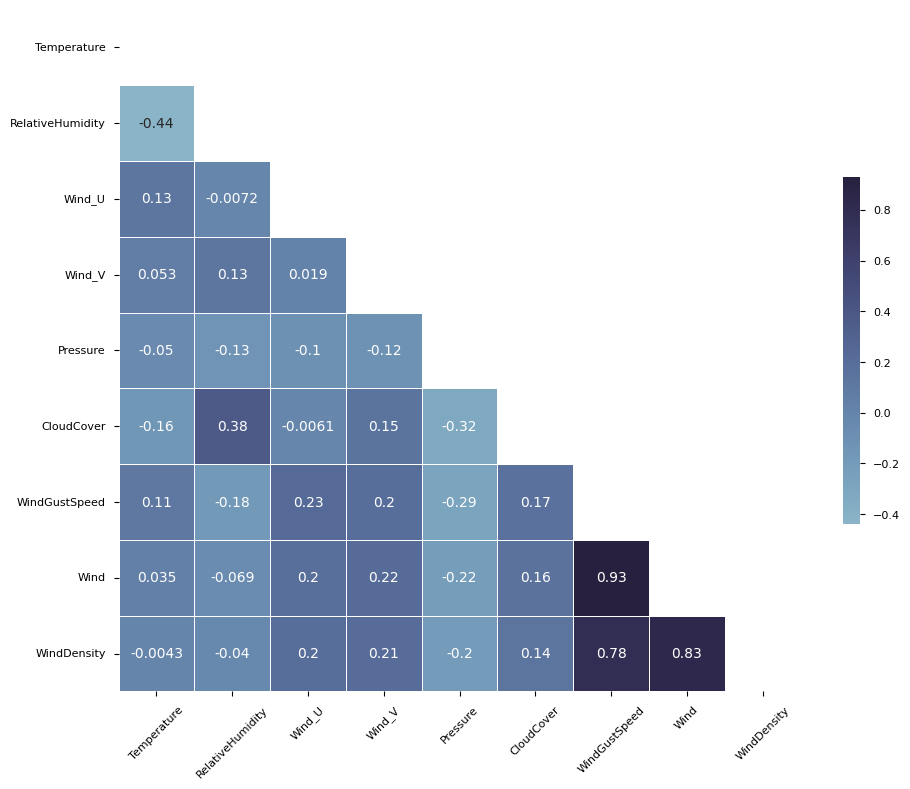

In [51]:
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(11, 9))

cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink":.5}, ax=ax, annot=True)
ax.tick_params("x",labelrotation=45)
ax.tick_params("y",labelrotation=0)
fig.savefig(DIRPATH + "/reports/plots/correlation_NWP_var_plot.pdf", bbox_inches='tight')

In [52]:
start, end = "20000101", "20001231"
ds_power = load_wind_power(start="20000101", end="20001231", adjust=True)

max_power = np.concatenate((load_max_power(start=start, end=end, SE="SE1", SE1_adjusted=True),
                                         load_max_power(start=start, end=end, SE="SE2"),
                                         load_max_power(start=start, end=end, SE="SE3"),
                                         load_max_power(start=start, end=end, SE="SE4")), axis=1)

In [53]:
ar_norm_power = ds_power.to_array().transpose('time','variable')/max_power
ar_norm_power_SE1 = ar_norm_power[:,0]
ar_norm_power_SE2 = ar_norm_power[:,1]
ar_norm_power_SE3 = ar_norm_power[:,2]
ar_norm_power_SE4 = ar_norm_power[:,3]

In [54]:
ds_NWP_SE1 = ds_NWP_mean.isel(y=slice(92,156), x=slice(7,71))
ds_NWP_SE2 = ds_NWP_mean.isel(y=slice(58,122), x=slice(7,71))
ds_NWP_SE3 = ds_NWP_mean.isel(y=slice(14,78), x=slice(1,65))
ds_NWP_SE4 = ds_NWP_mean.isel(y=slice(0,64), x=slice(0,64))

In [55]:
ds_NWP_SE1

<xarray.Dataset>
Dimensions:           (time: 8736, y: 64, x: 64)
Coordinates:
  * x                 (x) float32 -2.525e+05 -2.425e+05 ... 3.675e+05 3.775e+05
  * y                 (y) float32 4.067e+04 5.067e+04 ... 6.607e+05 6.707e+05
  * time              (time) datetime64[ns] 2000-01-01 ... 2000-12-31T23:00:00
    latitude          (y, x) float64 63.28 63.28 63.29 63.3 ... 68.8 68.79 68.77
    longitude         (y, x) float64 9.945 10.14 10.34 ... 23.87 24.11 24.36
Data variables:
    Temperature       (time, y, x) float32 267.2 268.6 270.3 ... 260.3 259.4
    RelativeHumidity  (time, y, x) float32 0.9202 0.8915 0.8197 ... 0.9246 0.94
    Wind_U            (time, y, x) float32 -2.846 -0.7943 -3.312 ... 2.853 2.666
    Wind_V            (time, y, x) float32 2.363 5.737 6.81 ... -5.565 -4.053
    Pressure          (time, y, x) float32 9.825e+04 9.825e+04 ... 1.012e+05
    CloudCover        (time, y, x) float32 0.8026 0.8471 ... 0.4412 0.5189
    WindGustSpeed     (time, y, x) float32 6.793 11.27 14.58 ... 9.249 7.154
    Wind              (time, y, x) float32 3.699 5.792 7.572 ... 6.253 4.851
    WindDensity       (time, y, x) float32 19.21 73.36 162.9 ... 98.11 45.97

In [56]:
result_corr = np.zeros((4,9))
for i, ds_NWP_SE in enumerate([ds_NWP_SE1, ds_NWP_SE2, ds_NWP_SE3, ds_NWP_SE4]):
    for j, var in enumerate(ds_NWP_SE.data_vars):
        result_corr[i,j] =  xr.corr(ar_norm_power[:,i],ds_NWP_SE[var].mean(dim=["x","y"])).values

In [57]:
result_corr

array([[ 0.03653294,  0.07854028,  0.46589132,  0.00514642, -0.19589287,
         0.11871226,  0.65278429,  0.63589166,  0.51140586],
       [ 0.00436986,  0.09466646,  0.42821873,  0.14788377, -0.24939997,
         0.12433857,  0.73455596,  0.76012769,  0.65733067],
       [-0.11820178,  0.11034124,  0.28646715,  0.30024525, -0.20812699,
         0.13200669,  0.7895106 ,  0.84627839,  0.75149291],
       [-0.2046816 ,  0.028375  ,  0.10869595,  0.18898439, -0.18484697,
         0.14749711,  0.78840359,  0.83814689,  0.79122566]])

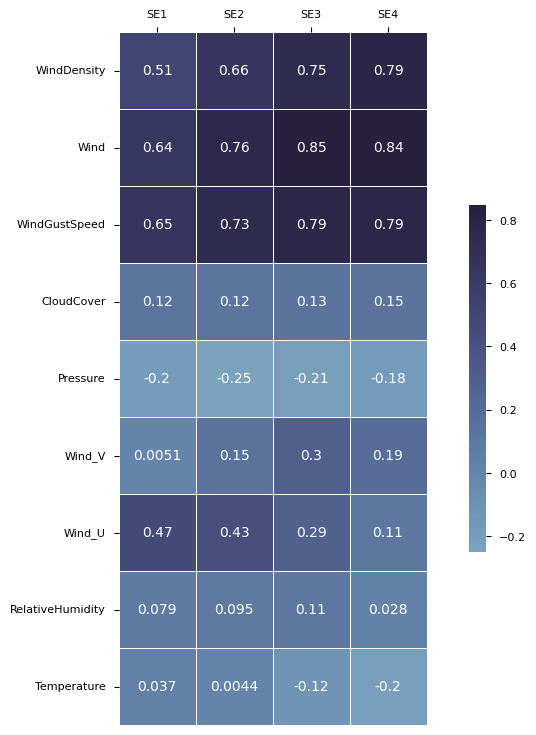

In [58]:
fig, ax = plt.subplots(figsize=(11, 9))

cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

sns.heatmap(result_corr.T, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink":.5}, ax=ax, annot=True)
ax.tick_params("x",labelrotation=0)
ax.tick_params("y",labelrotation=0)
ax.set_xticks(np.arange(result_corr.T.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(result_corr.T.shape[0]) + 0.5, minor=False)
ax.xaxis.tick_top()
ax.invert_yaxis()
ax.set_xticklabels(["SE1","SE2", "SE3", "SE4"], minor=False)
ax.set_yticklabels(ds_NWP_SE1.data_vars, minor=False)
fig.savefig(DIRPATH + "/reports/plots/correlation_TS_NWPmean_var_plot.pdf", bbox_inches='tight')

#### Creating uncertainty features

In [59]:
ds_NWP_day1 = xr.open_dataset(DIRPATH+"/data/eem20/raw/20000101T00Z.nc")
ds_NWP_day1 = ds_NWP_day1.drop_vars("CloudCover")

In [60]:
ds_NWP_mean_mean = ds_NWP_mean.mean()
ds_NWP_mean_std = ds_NWP_mean.std()

In [61]:
ds_NWP_day1_norm = (ds_NWP_day1 - ds_NWP_mean_mean)/ds_NWP_mean_std

In [62]:
ds_NWP_day1_norm_std = ds_NWP_day1_norm.std(dim="ensemble_member")

In [63]:
ds_NWP_day1_norm_std.mean(dim=["x","y"])

<xarray.Dataset>
Dimensions:           (time: 24)
Coordinates:
  * time              (time) datetime64[ns] 2000-01-01 ... 2000-01-01T23:00:00
Data variables:
    Temperature       (time) float32 0.07309 0.07321 0.07321 ... 0.07588 0.07888
    RelativeHumidity  (time) float32 0.1491 0.1449 0.138 ... 0.1615 0.1664
    Wind_U            (time) float32 0.2381 0.2436 0.2486 ... 0.3215 0.3294
    Wind_V            (time) float32 0.2269 0.2292 0.2347 ... 0.3364 0.3405
    Pressure          (time) float32 0.06008 0.06026 0.06409 ... 0.09358 0.09583
    WindGustSpeed     (time) float32 0.3104 0.3145 0.318 ... 0.38 0.3869 0.3915

In [65]:
files= list(pd.date_range(start="20000101", end="20011231", freq="D").strftime("%Y%m%d") + "T00Z.nc")
dirname = DIRPATH + "/data/eem20/raw"

ds = xr.open_dataset(os.path.join(dirname,files.pop(0)))
ds = ds.drop_vars("CloudCover")
ds = ds.assign(Wind=np.sqrt(ds.Wind_U**2 + ds.Wind_V**2))
ds = ds.assign(WindDensity= (ds.Pressure/(287.05*ds.Temperature))*(8/27)* (ds.Wind**3) )
ds_SE1 = ds.isel(y=slice(92,156), x=slice(7,71))
ds_SE2 = ds.isel(y=slice(58,122), x=slice(7,71))
ds_SE3 = ds.isel(y=slice(14,78), x=slice(1,65))
ds_SE4 = ds.isel(y=slice(0,64), x=slice(0,64))

ds_SE1 = (ds_SE1 - ds_NWP_mean_mean)/ds_NWP_mean_std
ds_SE2 = (ds_SE2 - ds_NWP_mean_mean)/ds_NWP_mean_std
ds_SE3 = (ds_SE3 - ds_NWP_mean_mean)/ds_NWP_mean_std
ds_SE4 = (ds_SE4 - ds_NWP_mean_mean)/ds_NWP_mean_std

ds_SE1 = ds_SE1.std(dim="ensemble_member").mean(dim=["x","y"])
ds_SE2 = ds_SE2.std(dim="ensemble_member").mean(dim=["x","y"])
ds_SE3 = ds_SE3.std(dim="ensemble_member").mean(dim=["x","y"])
ds_SE4 = ds_SE4.std(dim="ensemble_member").mean(dim=["x","y"])

for day in tqdm(files):
    if os.path.isfile(os.path.join(dirname,day)):
        temp_ds = xr.open_dataset(os.path.join(dirname,day))
        temp_ds = temp_ds.drop_vars("CloudCover")
        temp_ds = temp_ds.assign(Wind=np.sqrt(temp_ds.Wind_U**2 + temp_ds.Wind_V**2))
        temp_ds = temp_ds.assign(WindDensity= (temp_ds.Pressure/(287.05*temp_ds.Temperature))*(8/27)* (temp_ds.Wind**3) )
        temp_ds_SE1 = temp_ds.isel(y=slice(92,156), x=slice(7,71))
        temp_ds_SE2 = temp_ds.isel(y=slice(58,122), x=slice(7,71))
        temp_ds_SE3 = temp_ds.isel(y=slice(14,78), x=slice(1,65))
        temp_ds_SE4 = temp_ds.isel(y=slice(0,64), x=slice(0,64))

        temp_ds_SE1 = (temp_ds_SE1 - ds_NWP_mean_mean)/ds_NWP_mean_std
        temp_ds_SE2 = (temp_ds_SE2 - ds_NWP_mean_mean)/ds_NWP_mean_std
        temp_ds_SE3 = (temp_ds_SE3 - ds_NWP_mean_mean)/ds_NWP_mean_std
        temp_ds_SE4 = (temp_ds_SE4 - ds_NWP_mean_mean)/ds_NWP_mean_std

        temp_ds_SE1 = temp_ds_SE1.std(dim="ensemble_member").mean(dim=["x","y"])
        temp_ds_SE2 = temp_ds_SE2.std(dim="ensemble_member").mean(dim=["x","y"])
        temp_ds_SE3 = temp_ds_SE3.std(dim="ensemble_member").mean(dim=["x","y"])
        temp_ds_SE4 = temp_ds_SE4.std(dim="ensemble_member").mean(dim=["x","y"])
        
        ds_SE1 = ds_SE1.combine_first(temp_ds_SE1)
        ds_SE2 = ds_SE2.combine_first(temp_ds_SE2)
        ds_SE3 = ds_SE3.combine_first(temp_ds_SE3)
        ds_SE4 = ds_SE4.combine_first(temp_ds_SE4)

100%|██████████| 730/730 [05:41<00:00,  2.14it/s]


In [66]:
ds_SE1.to_netcdf(DIRPATH+"/data/eem20/processed/NWP_ensemble_std_SE1.nc",format="NETCDF4")
ds_SE2.to_netcdf(DIRPATH+"/data/eem20/processed/NWP_ensemble_std_SE2.nc",format="NETCDF4")
ds_SE3.to_netcdf(DIRPATH+"/data/eem20/processed/NWP_ensemble_std_SE3.nc",format="NETCDF4")
ds_SE4.to_netcdf(DIRPATH+"/data/eem20/processed/NWP_ensemble_std_SE4.nc",format="NETCDF4")

#### Creating temparature features

In [5]:
ds_tillend = xr.open_dataset(DIRPATH + "/data/eem20/processed/EEM2020_tilltask6.nc")

In [18]:
ds_temp_SE1 = ds_tillend.Temperature.isel(y=slice(92,156), x=slice(7,71)).mean(dim=["x","y"])
ds_temp_SE2 = ds_tillend.Temperature.isel(y=slice(58,122), x=slice(7,71)).mean(dim=["x","y"])
ds_temp_SE3 = ds_tillend.Temperature.isel(y=slice(14,78), x=slice(1,65)).mean(dim=["x","y"])
ds_temp_SE4 = ds_tillend.Temperature.isel(y=slice(0,64), x=slice(0,64)).mean(dim=["x","y"])


In [19]:
ds_temp_SE1.to_netcdf(DIRPATH+"/data/eem20/processed/NWP_mean_temp_SE1.nc",format="NETCDF4")
ds_temp_SE2.to_netcdf(DIRPATH+"/data/eem20/processed/NWP_mean_temp_SE2.nc",format="NETCDF4")
ds_temp_SE3.to_netcdf(DIRPATH+"/data/eem20/processed/NWP_mean_temp_SE3.nc",format="NETCDF4")
ds_temp_SE4.to_netcdf(DIRPATH+"/data/eem20/processed/NWP_mean_temp_SE4.nc",format="NETCDF4")

## Time Series

In [68]:
start = "20000101"
end = "20011231"
adjust=False
power_data = load_wind_power(start,end,adjust=adjust).to_dataframe()
time_index = power_data.index
power_data_np = np.array(power_data)
max_power_np = np.concatenate((load_max_power(start=start, end=end, SE="SE1", adjust=adjust, SE1_adjusted=True),
                                 load_max_power(start=start, end=end, SE="SE2", adjust=adjust),
                                 load_max_power(start=start, end=end, SE="SE3", adjust=adjust),
                                 load_max_power(start=start, end=end, SE="SE4", adjust=adjust)), axis=1)
power_data_norm_np = power_data_np / max_power_np

power_data_norm = pd.DataFrame(power_data_norm_np, index= power_data.index, columns=["SE1","SE2","SE3","SE4"])
max_power = pd.DataFrame(max_power_np, index= power_data.index, columns=["SE1","SE2","SE3","SE4"])

In [69]:
# ds_NWP_mean = xr.open_dataset(DIRPATH + "/data/eem20/processed/EEM2020_2000.nc")
# ds_NWP_mean = ds_NWP_mean.combine_first(xr.open_dataset(DIRPATH + "/data/eem20/processed/EEM2020_task1.nc"))
# ds_NWP_mean = ds_NWP_mean.combine_first(xr.open_dataset(DIRPATH + "/data/eem20/processed/EEM2020_task2.nc"))
# ds_NWP_mean = ds_NWP_mean.combine_first(xr.open_dataset(DIRPATH + "/data/eem20/processed/EEM2020_task3.nc"))
# ds_NWP_mean = ds_NWP_mean.combine_first(xr.open_dataset(DIRPATH + "/data/eem20/processed/EEM2020_task4.nc"))
# ds_NWP_mean = ds_NWP_mean.combine_first(xr.open_dataset(DIRPATH + "/data/eem20/processed/EEM2020_task5.nc"))
# ds_NWP_mean = ds_NWP_mean.combine_first(xr.open_dataset(DIRPATH + "/data/eem20/processed/EEM2020_task6.nc"))

In [70]:
# ds_NWP_mean = ds_NWP_mean.assign(Wind=np.sqrt(ds_NWP_mean.Wind_U**2 + ds_NWP_mean.Wind_V**2))

In [71]:
# ar_NWP_SE1_mean = ds_NWP_mean.Wind.isel(y=slice(92,156), x=slice(7,71)).mean(dim=["x","y"])
# ar_NWP_SE2_mean = ds_NWP_mean.Wind.isel(y=slice(58,122), x=slice(7,71)).mean(dim=["x","y"])
# ar_NWP_SE3_mean = ds_NWP_mean.Wind.isel(y=slice(14,78), x=slice(1,65)).mean(dim=["x","y"])
# ar_NWP_SE4_mean = ds_NWP_mean.Wind.isel(y=slice(0,64), x=slice(0,64)).mean(dim=["x","y"])

### Persistence


#### SE1

In [72]:
series_SE1 = power_data_norm["SE1"]
series_SE1_train = series_SE1[:24*366]

In [73]:
MAE = 0
RSME = 0
NMAE = 0
NRSME = 0
MAPE = 0
pred_SE1 = np.zeros((365,24))
for i in range(365):
    pred = series_SE1[24*366+i*24-12]
    pred_SE1[i] += pred
    errors = series_SE1[24*366+i*24:24*366+(i+1)*24]- pred
    NMAE += np.mean(abs(errors))
    NRSME += np.mean(errors**2)
    MAE += np.mean(abs(errors)* max_power["SE1"][24*366+i*24])
    RSME += np.mean((errors* max_power["SE1"][24*366+i*24])**2)
    MAPE += np.mean(abs(errors)/series_SE1[24*366+i*24:24*366+(i+1)*24])

In [74]:
MAE /= 365
RSME /= 365
NMAE /= 365
NRSME /= 365
MAPE /= 365

In [75]:
print("MAE:",MAE)
print("RSME:",RSME)
print("NMAE:",NMAE)
print("NRSME:",NRSME)
print("MAPE:",MAPE)

MAE: 187.2231472909036
RSME: 67030.80529723717
NMAE: 0.17312085535420793
NRSME: 0.05691440238382614
MAPE: 12.26215853250234


#### SE2

In [76]:
series_SE2 = power_data_norm["SE2"]
series_SE2_train = series_SE2[:24*366]

In [77]:
MAE = 0
RSME = 0
NMAE = 0
NRSME = 0
MAPE = 0
pred_SE2 = np.zeros((365,24))
for i in range(365):
    pred = series_SE2[24*366+i*24-12]
    errors = series_SE2[24*366+i*24:24*366+(i+1)*24]- pred
    pred_SE2[i] += pred
    NMAE += np.mean(abs(errors))
    NRSME += np.mean(errors**2)
    MAE += np.mean(abs(errors)* max_power["SE2"][24*366+i*24])
    RSME += np.mean((errors* max_power["SE2"][24*366+i*24])**2)
    MAPE += np.mean(abs(errors)/series_SE2[24*366+i*24:24*366+(i+1)*24])

In [78]:
MAE /= 365
RSME /= 365
NMAE /= 365
NRSME /= 365
MAPE /= 365

In [79]:
print("MAE:",MAE)
print("RSME:",RSME)
print("NMAE:",NMAE)
print("NRSME:",NRSME)
print("MAPE:",MAPE)

MAE: 440.5105173916944
RSME: 356376.90509564255
NMAE: 0.17023351019009775
NRSME: 0.05303945490741994
MAPE: 1.807630394647151


#### SE3

In [80]:
series_SE3 = power_data_norm["SE3"]
series_SE3_train = series_SE3[:24*366]

In [81]:
MAE = 0
RSME = 0
NMAE = 0
NRSME = 0
MAPE = 0
pred_SE3 = np.zeros((365,24))
for i in range(365):
    pred = series_SE3[24*366+i*24-12]
    errors = series_SE3[24*366+i*24:24*366+(i+1)*24]- pred
    pred_SE3[i] += pred
    NMAE += np.mean(abs(errors))
    NRSME += np.mean(errors**2)
    MAE += np.mean(abs(errors)* max_power["SE3"][24*366+i*24])
    RSME += np.mean((errors* max_power["SE3"][24*366+i*24])**2)
    MAPE += np.mean(abs(errors)/series_SE3[24*366+i*24:24*366+(i+1)*24])

In [82]:
MAE /= 365
RSME /= 365
NMAE /= 365
NRSME /= 365
MAPE /= 365

In [83]:
print("MAE:",MAE)
print("RSME:",RSME)
print("NMAE:",NMAE)
print("NRSME:",NRSME)
print("MAPE:",MAPE)

MAE: 478.1674187066973
RSME: 398318.3839730871
NMAE: 0.1894345969444327
NRSME: 0.0626816439861215
MAPE: 1.2079162909978667


#### SE4

In [84]:
series_SE4 = power_data_norm["SE4"]
series_SE4_train = series_SE4[:24*366]

In [85]:
MAE = 0
RSME = 0
NMAE = 0
NRSME = 0
MAPE = 0
pred_SE4 = np.zeros((365,24))
for i in range(365):
    pred = series_SE4[24*366+i*24-12]
    errors = series_SE4[24*366+i*24:24*366+(i+1)*24]- pred
    pred_SE4[i] += pred
    NMAE += np.mean(abs(errors))
    NRSME += np.mean(errors**2)
    MAE += np.mean(abs(errors)* max_power["SE4"][24*366+i*24])
    RSME += np.mean((errors* max_power["SE4"][24*366+i*24])**2)
    MAPE += np.mean(abs(errors)/series_SE4[24*366+i*24:24*366+(i+1)*24])

In [86]:
MAE /= 365
RSME /= 365
NMAE /= 365
NRSME /= 365
MAPE /= 365

In [87]:
print("MAE:",MAE)
print("RSME:",RSME)
print("NMAE:",NMAE)
print("NRSME:",NRSME)
print("MAPE:",MAPE)

MAE: 317.1304940031838
RSME: 173070.2999392274
NMAE: 0.19470962590235544
NRSME: 0.06525234654155845
MAPE: 1.5573810008870042


#### Evaluate metrics

In [88]:
df_per_SE1 = pd.DataFrame({"pred":pred_SE1.flatten(), "target":series_SE1[366*24:], "max_power":max_power["SE1"][366*24:], "time":power_data_norm.index[366*24:], "SE":["SE1"for i in range(365*24)]})
df_per_SE2 = pd.DataFrame({"pred":pred_SE2.flatten(), "target":series_SE2[366*24:], "max_power":max_power["SE2"][366*24:], "time":power_data_norm.index[366*24:], "SE":["SE2"for i in range(365*24)]})
df_per_SE3 = pd.DataFrame({"pred":pred_SE3.flatten(), "target":series_SE3[366*24:], "max_power":max_power["SE3"][366*24:], "time":power_data_norm.index[366*24:], "SE":["SE3"for i in range(365*24)]})
df_per_SE4 = pd.DataFrame({"pred":pred_SE4.flatten(), "target":series_SE4[366*24:], "max_power":max_power["SE4"][366*24:], "time":power_data_norm.index[366*24:], "SE":["SE4"for i in range(365*24)]})
df_per = pd.concat([df_per_SE1.reset_index(drop=True), df_per_SE2.reset_index(drop=True), df_per_SE3.reset_index(drop=True), df_per_SE4.reset_index(drop=True)], 0)

In [89]:
df_per["MAE"] = abs(df_per["pred"] - df_per["target"])*df_per["max_power"]
df_per["RMSE"] = ((df_per["pred"] - df_per["target"])*df_per["max_power"])**2
df_per["MAPE"] = (df_per["pred"] - df_per["target"])/df_per["target"]
df_per["NMAE"] = abs(df_per["pred"] - df_per["target"])
df_per["NRMSE"] = (df_per["pred"] - df_per["target"])**2
df_per["SSTot"] = (df_per["target"] - np.mean(df_per["target"]))**2

In [90]:
np.mean(df_per["target"])

0.28612348840966145

In [91]:
df_per_task1 = df_per[("2001-01-01"<=df_per["time"]) & (df_per["time"] <"2001-03-01")]
df_per_task2 = df_per[("2001-03-01"<=df_per["time"]) & (df_per["time"] <"2001-05-01")]
df_per_task3 = df_per[("2001-05-01"<=df_per["time"]) & (df_per["time"] <"2001-07-01")]
df_per_task4 = df_per[("2001-07-01"<=df_per["time"]) & (df_per["time"] <"2001-09-01")]
df_per_task5 = df_per[("2001-09-01"<=df_per["time"]) & (df_per["time"] <"2001-11-01")]
df_per_task6 = df_per[("2001-11-01"<=df_per["time"]) & (df_per["time"] <"2002-01-01")]

In [92]:
print("MAE:",df_per_task1["MAE"].mean())
print("RMSE:",math.sqrt(df_per_task1["RMSE"].mean()))
print("NMAE:",df_per_task1["NMAE"].mean())
print("NRMSE:",math.sqrt(df_per_task1["NRMSE"].mean()))
print("MAPE:",df_per_task1["MAPE"].mean())
print("R2:", 1 - df_per_task1["NRMSE"].sum()/df_per_task1["SSTot"].sum())

MAE: 406.6937602837868
RMSE: 550.4957766077807
NMAE: 0.2157028216076479
NRMSE: 0.27911354516197495
MAPE: 1.0024023103804414
R2: -0.2854380177686766


In [93]:
print("MAE SE1:", df_per_task1[df_per_task1["SE"]=="SE1"]["MAE"].mean())
print("MAE SE2:", df_per_task1[df_per_task1["SE"]=="SE2"]["MAE"].mean())
print("MAE SE3:", df_per_task1[df_per_task1["SE"]=="SE3"]["MAE"].mean())
print("MAE SE4:", df_per_task1[df_per_task1["SE"]=="SE4"]["MAE"].mean())

MAE SE1: 209.89638835672932
MAE SE2: 487.6143688851082
MAE SE3: 557.5153506455828
MAE SE4: 371.74893324772677


In [94]:
print("MAE:",df_per_task2["MAE"].mean())
print("RMSE:",math.sqrt(df_per_task2["RMSE"].mean()))
print("NMAE:",df_per_task2["NMAE"].mean())
print("NRMSE:",math.sqrt(df_per_task2["NRMSE"].mean()))
print("MAPE:",df_per_task2["MAPE"].mean())
print("R2:", 1 - df_per_task2["NRMSE"].sum()/df_per_task2["SSTot"].sum())

MAE: 391.81507927032106
RMSE: 535.8220921866356
NMAE: 0.20523689700137726
NRMSE: 0.2689229589671435
MAPE: 2.1378466757963848
R2: -0.2294459223762746


In [95]:
print("MAE SE1:", df_per_task2[df_per_task2["SE"]=="SE1"]["MAE"].mean())
print("MAE SE2:", df_per_task2[df_per_task2["SE"]=="SE2"]["MAE"].mean())
print("MAE SE3:", df_per_task2[df_per_task2["SE"]=="SE3"]["MAE"].mean())
print("MAE SE4:", df_per_task2[df_per_task2["SE"]=="SE4"]["MAE"].mean())

MAE SE1: 191.90640997950823
MAE SE2: 462.3441494071038
MAE SE3: 550.2524273265027
MAE SE4: 362.75733036816945


In [96]:
print("MAE:",df_per_task3["MAE"].mean())
print("RMSE:",math.sqrt(df_per_task3["RMSE"].mean()))
print("NMAE:",df_per_task3["NMAE"].mean())
print("NRMSE:",math.sqrt(df_per_task3["NRMSE"].mean()))
print("MAPE:",df_per_task3["MAPE"].mean())
print("R2:", 1 - df_per_task3["NRMSE"].sum()/df_per_task3["SSTot"].sum())

MAE: 373.71796992008194
RMSE: 515.3798304385739
NMAE: 0.19496521586767826
NRMSE: 0.25619533905504294
MAPE: 2.978559206045453
R2: -0.6570227183652979


In [97]:
print("MAE SE1:", df_per_task3[df_per_task3["SE"]=="SE1"]["MAE"].mean())
print("MAE SE2:", df_per_task3[df_per_task3["SE"]=="SE2"]["MAE"].mean())
print("MAE SE3:", df_per_task3[df_per_task3["SE"]=="SE3"]["MAE"].mean())
print("MAE SE4:", df_per_task3[df_per_task3["SE"]=="SE4"]["MAE"].mean())

MAE SE1: 180.04341652800548
MAE SE2: 466.2414621099727
MAE SE3: 509.68537353551915
MAE SE4: 338.9016275068306


In [98]:
print("MAE:",df_per_task4["MAE"].mean())
print("RMSE:",math.sqrt(df_per_task4["RMSE"].mean()))
print("NMAE:",df_per_task4["NMAE"].mean())
print("NRMSE:",math.sqrt(df_per_task4["NRMSE"].mean()))
print("MAPE:",df_per_task4["MAPE"].mean())
print("R2:", 1 - df_per_task4["NRMSE"].sum()/df_per_task4["SSTot"].sum())

MAE: 255.28764757453382
RMSE: 369.21468304584977
NMAE: 0.13284874411285172
NRMSE: 0.18292634144149586
MAPE: 1.1208261989993058
R2: 0.056752322479891704


In [99]:
print("MAE SE1:", df_per_task4[df_per_task4["SE"]=="SE1"]["MAE"].mean())
print("MAE SE2:", df_per_task4[df_per_task4["SE"]=="SE2"]["MAE"].mean())
print("MAE SE3:", df_per_task4[df_per_task4["SE"]=="SE3"]["MAE"].mean())
print("MAE SE4:", df_per_task4[df_per_task4["SE"]=="SE4"]["MAE"].mean())

MAE SE1: 131.53963712535295
MAE SE2: 313.73759502824146
MAE SE3: 349.0447366929279
MAE SE4: 226.82862145161292


In [100]:
print("MAE:",df_per_task5["MAE"].mean())
print("RMSE:",math.sqrt(df_per_task5["RMSE"].mean()))
print("NMAE:",df_per_task5["NMAE"].mean())
print("NRMSE:",math.sqrt(df_per_task5["NRMSE"].mean()))
print("MAPE:",df_per_task5["MAPE"].mean())
print("R2:", 1 - df_per_task5["NRMSE"].sum()/df_per_task5["SSTot"].sum())

MAE: 352.83919792113807
RMSE: 497.10960624739675
NMAE: 0.1749474944481269
NRMSE: 0.23519664818298058
MAPE: 1.19327310355239
R2: -0.2821149333531283


In [101]:
print("MAE SE1:", df_per_task5[df_per_task5["SE"]=="SE1"]["MAE"].mean())
print("MAE SE2:", df_per_task5[df_per_task5["SE"]=="SE2"]["MAE"].mean())
print("MAE SE3:", df_per_task5[df_per_task5["SE"]=="SE3"]["MAE"].mean())
print("MAE SE4:", df_per_task5[df_per_task5["SE"]=="SE4"]["MAE"].mean())

MAE SE1: 203.65880271294856
MAE SE2: 465.46234220212546
MAE SE3: 451.781495301582
MAE SE4: 290.4541514678962


In [102]:
print("MAE:",df_per_task6["MAE"].mean())
print("RMSE:",math.sqrt(df_per_task6["RMSE"].mean()))
print("NMAE:",df_per_task6["NMAE"].mean())
print("NRMSE:",math.sqrt(df_per_task6["NRMSE"].mean()))
print("MAPE:",df_per_task6["MAPE"].mean())
print("R2:", 1 - df_per_task6["NRMSE"].sum()/df_per_task6["SSTot"].sum())

MAE: 357.51079273598737
RMSE: 506.57082999096997
NMAE: 0.16945953335231362
NRMSE: 0.230701137089213
MAPE: 13.37849324139955
R2: 0.1835199973073366


In [103]:
print("MAE SE1:", df_per_task6[df_per_task6["SE"]=="SE1"]["MAE"].mean())
print("MAE SE2:", df_per_task6[df_per_task6["SE"]=="SE2"]["MAE"].mean())
print("MAE SE3:", df_per_task6[df_per_task6["SE"]=="SE3"]["MAE"].mean())
print("MAE SE4:", df_per_task6[df_per_task6["SE"]=="SE4"]["MAE"].mean())

MAE SE1: 207.95045842479794
MAE SE2: 451.2858199200821
MAE SE3: 455.4434655559627
MAE SE4: 315.36342704310664
